In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP, SGLRP2, OAGLRP
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img
from keras.datasets import cifar100
from keras.utils import to_categorical
import math

os.environ["CUDA_VISIBLE_DEVICES"]="3"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_shape = (32, 32, 3)
num_classes = 100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [3]:
# This will be your trained model instead.

from utils.models import LeNet, VGGMini, VGGMini2, VGGMini2_nodrop, preprocess_input
model = VGGMini2_nodrop(
    input_shape=input_shape,
    nb_class=num_classes
)
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [4]:
x_train = preprocess_input(x_train, input_shape[0], input_shape[1], input_shape[2])
x_test = preprocess_input(x_test, input_shape[0], input_shape[1], input_shape[2])

In [5]:
#train
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

nb_iterations = 50000
learning_rate=0.0001
batch_size=128
nb_epochs = math.ceil(nb_iterations * (batch_size / x_train.shape[0]))
dataset_prefix="cifar100_VGGmini2_nodrop"

save=True
train=True

validation_split=0.0025

if not os.path.exists(os.path.join("logs", "%s" % (dataset_prefix))):
    os.mkdir(os.path.join("logs", "%s" % (dataset_prefix)))
tensorboard = TensorBoard(log_dir=os.path.join("logs", "%s" % (dataset_prefix)), batch_size=batch_size)
csv_logger = CSVLogger(os.path.join('logs', '%s.csv' % (dataset_prefix)))

if not save:
    callback_list = []
else:
    callback_list = [tensorboard, csv_logger]
    #callback_list = [model_checkpoint, reduce_lr, tensorboard, csv_logger]


optm = Adam(lr=learning_rate)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

if train:
    #train
    model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, callbacks=callback_list, verbose=1, validation_split=validation_split)
    if save:
        model.save_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))
else:
    model.load_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))

Train on 49875 samples, validate on 125 samples
Epoch 1/128
49875/49875 [==============================] - 147s 3ms/step - loss: 3.6719 - acc: 0.1562 - val_loss: 3.3728 - val_acc: 0.1920
Epoch 2/128
49875/49875 [==============================] - 148s 3ms/step - loss: 2.9164 - acc: 0.2892 - val_loss: 2.8462 - val_acc: 0.3120
Epoch 3/128
49875/49875 [==============================] - 150s 3ms/step - loss: 2.4832 - acc: 0.3765 - val_loss: 2.6063 - val_acc: 0.4080
Epoch 4/128
49875/49875 [==============================] - 149s 3ms/step - loss: 2.1270 - acc: 0.4537 - val_loss: 2.4624 - val_acc: 0.3840
Epoch 5/128
49875/49875 [==============================] - 150s 3ms/step - loss: 1.7883 - acc: 0.5311 - val_loss: 2.4383 - val_acc: 0.4000
Epoch 6/128
49875/49875 [==============================] - 150s 3ms/step - loss: 1.4546 - acc: 0.6102 - val_loss: 2.3048 - val_acc: 0.4240
Epoch 7/128
49875/49875 [==============================] - 149s 3ms/step - loss: 1.1074 - acc: 0.7007 - val_loss: 2.45

49875/49875 [==============================] - 149s 3ms/step - loss: 0.0176 - acc: 0.9953 - val_loss: 5.1841 - val_acc: 0.4000
Epoch 60/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0161 - acc: 0.9958 - val_loss: 5.1667 - val_acc: 0.3760
Epoch 61/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0160 - acc: 0.9960 - val_loss: 5.0401 - val_acc: 0.4000
Epoch 62/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0218 - acc: 0.9946 - val_loss: 5.2126 - val_acc: 0.3920
Epoch 63/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0149 - acc: 0.9961 - val_loss: 5.6447 - val_acc: 0.3840
Epoch 64/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0224 - acc: 0.9941 - val_loss: 5.0713 - val_acc: 0.4240
Epoch 65/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0203 - acc: 0.9941 - val_loss: 5.0517 - val_acc: 0.4240
Epoch 66/128
49875/49875 [=======

49875/49875 [==============================] - 149s 3ms/step - loss: 0.0092 - acc: 0.9976 - val_loss: 5.0666 - val_acc: 0.5040
Epoch 118/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0138 - acc: 0.9962 - val_loss: 5.4601 - val_acc: 0.4640
Epoch 119/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 5.2238 - val_acc: 0.4800
Epoch 120/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0037 - acc: 0.9992 - val_loss: 5.2638 - val_acc: 0.4720
Epoch 121/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 5.4305 - val_acc: 0.4480
Epoch 122/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0148 - acc: 0.9958 - val_loss: 5.3700 - val_acc: 0.4000
Epoch 123/128
49875/49875 [==============================] - 149s 3ms/step - loss: 0.0125 - acc: 0.9959 - val_loss: 5.6200 - val_acc: 0.4320
Epoch 124/128
49875/49875 [

In [6]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [7]:
# Range of input images
# keras_applications VGG16 weights assume a range of (-127.5, 127.5). Change this to a range suitable for your model.
max_input = -1.
min_input = 1.

In [8]:
# Change this to load a list of images you want. For this example, we are only loading one image, but you can load a list of files.
orig_imgs = x_test
input_imgs = np.copy(orig_imgs[:200])
print(np.shape(input_imgs))


(200, 32, 32, 3)


In [69]:
# Select only one from your list for example
example_id = 4

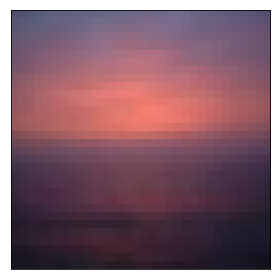

In [70]:
plt.imshow((orig_imgs[example_id]+1.)/2.)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [71]:


# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "max_pooling2d_2" # VGG only

In [72]:
# Optional
predictions = model.predict(input_imgs)

In [68]:
# for i, p in enumerate(predictions):
#     if np.max(p) < 1. :
#         print(i, np.max(p))
for i, p in enumerate(predictions):
    if np.argmax(p) == np.argmax(y_test[i]):
        print(i)

4
11
12
13
14
16
18
20
22
26
27
30
32
34
37
38
39
44
45
47
51
52
53
56
57
58
61
68
75
76
77
80
82
83
85
91
92
93
94
95
104
105
106
107
109
111
112
114
117
119
120
123
124
126
128
131
135
136
138
140
141
142
145
147
154
160
163
166
168
169
170
173
174
175
177
179
182
187
188
193
194
195
197
198
199


In [74]:
# Which class you want to target.
target_class = 71

pred_id = np.argmax(predictions[example_id])
gt_id = np.argmax(y_test[example_id])
from utils.helper import get_cifar_label
print("probability:", predictions[example_id][target_class])
print("prediction id:", pred_id)
print("prediction:", get_cifar_label(pred_id))
print("gt id:", gt_id)
print("gt:", get_cifar_label(gt_id))
print("target id:", target_class)

probability: 0.7680475
prediction id: 71
prediction: sea
gt id: 71
gt: sea
target id: 71


# GradCAM

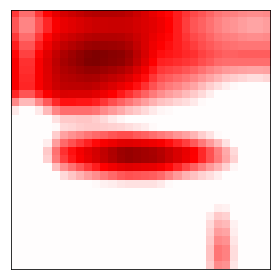

In [75]:
partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(input_imgs)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

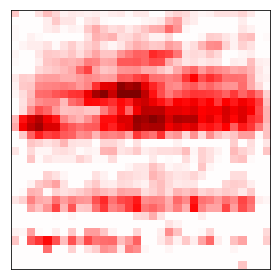

In [76]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=True,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(input_imgs)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

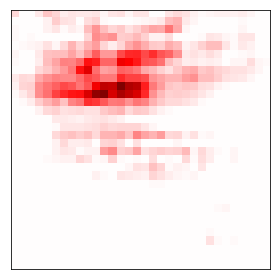

In [77]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(input_imgs)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

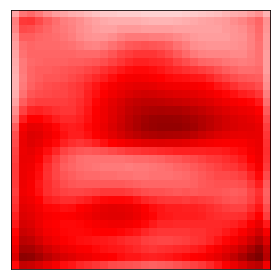

In [78]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

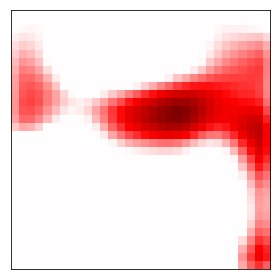

In [79]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

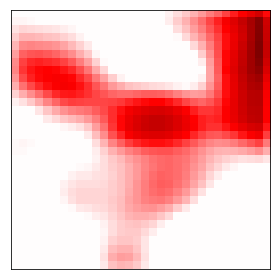

In [80]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()

In [21]:
# oaglrp_analyzer = OAGLRP(
#     partial_model,
#     target_id=target_class,
#     relu=False,
#     scaling=False,
#     low=min_input,
#     high=max_input,
# )
# analysis_oaglrp = oaglrp_analyzer.analyze(input_imgs)
# heatmap(analysis_oaglrp[example_id].sum(axis=(2)))
# plt.show()